In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import myd2l

In [ ]:
path = 'E:/Datasets/timemachine/timemachine.txt'
tokens = myd2l.tokenize(myd2l.read_time_machine(path))
corpus = [token for line in tokens for token in line]
vocab = myd2l.Vocab(corpus)
vocab.token_freqs[: 10]


[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674)]

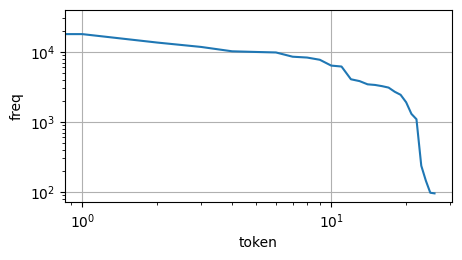

In [26]:
freqs = [freq for _, freq in vocab.token_freqs]
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.grid(True)
ax.set_xlabel('token')
ax.set_ylabel('freq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(range(len(freqs)), freqs)
plt.show()

In [ ]:
bigram_tokens=  [pair for pair in zip(corpus[: -1], corpus[1:])]
bigram_vocab = myd2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[: 10]


[(('e', ' '), 6037),
 ((' ', 't'), 5138),
 (('t', 'h'), 4616),
 (('h', 'e'), 3859),
 (('d', ' '), 3825),
 ((' ', 'a'), 3581),
 (('t', ' '), 3251),
 (('i', 'n'), 2935),
 (('s', ' '), 2910),
 ((' ', 'i'), 2722)]

In [ ]:
trigram_tokens=  [pair for pair in zip(corpus[: -2], corpus[1: -1], corpus[2:])]
trigram_vocab = myd2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[: 10]

[((' ', 't', 'h'), 3629),
 (('t', 'h', 'e'), 3127),
 (('h', 'e', ' '), 2205),
 (('n', 'd', ' '), 1483),
 (('a', 'n', 'd'), 1399),
 ((' ', 'a', 'n'), 1368),
 (('e', 'd', ' '), 1352),
 ((' ', 'o', 'f'), 1126),
 (('i', 'n', 'g'), 1101),
 ((' ', 'i', ' '), 1075)]

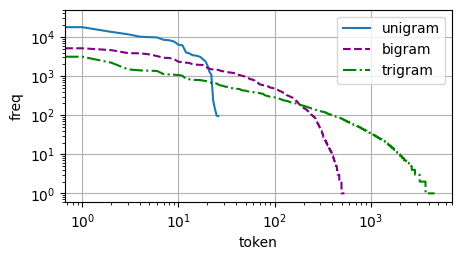

In [29]:
bigram_freqs = [freq for _, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for _, freq in trigram_vocab.token_freqs]

fig, ax = plt.subplots(figsize=(5, 2.5))
ax.grid(True)
ax.set_xlabel('token')
ax.set_ylabel('freq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(range(len(freqs)), freqs, label='unigram')
ax.plot(range(len(bigram_freqs)), bigram_freqs, label='bigram', c='purple', linestyle='--')
ax.plot(range(len(trigram_freqs)), trigram_freqs, label='trigram', c='g', linestyle='-.')
plt.legend()
plt.show()

In [30]:
def seq_data_iter_random(corpus, batch_size, n_steps):
    corpus = corpus[random.randint(0, n_steps - 1):]
    n_subseqs = (len(corpus) - 1) // n_steps
    initial_indices = list(range(0, n_subseqs * n_steps, n_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos: pos + n_steps]
    
    n_batches = n_subseqs // batch_size
    for i in range(0, batch_size * n_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [31]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, n_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]]) 
Y:  tensor([[19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28]])
X:  tensor([[28, 29, 30, 31, 32],
        [ 3,  4,  5,  6,  7]]) 
Y:  tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]])
X:  tensor([[13, 14, 15, 16, 17],
        [ 8,  9, 10, 11, 12]]) 
Y:  tensor([[14, 15, 16, 17, 18],
        [ 9, 10, 11, 12, 13]])


In [32]:
def seq_data_iter_sequential(corpus, batch_size, n_steps):
    offset = random.randint(0, n_steps)
    n_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + n_tokens]).reshape(batch_size, -1)
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + n_tokens]).reshape(batch_size, -1)
    n_batchs = Xs.shape[1] // n_steps
    for i in range(0, n_steps * n_batchs, n_steps):
        X = Xs[:, i: i + n_steps]
        Y = Ys[:, i: i + n_steps]
        yield X, Y

In [33]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, n_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y:  tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [34]:
class SeqDataLoader:
    def __init__(self, batch_size, n_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        
        self.corpus, self.vocab = myd2l.load_corpus_time_machine(max_tokens=max_tokens)
        self.batch_size, self.n_steps = batch_size, n_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.n_steps)

In [35]:
def load_data_time_machine(batch_size, n_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, n_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab